In [4]:
!pip install kagglehub kaggle -q

In [11]:
import kagglehub

In [24]:
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1


In [42]:
from pathlib import Path
import random

import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [51]:
DATASET_DIR = Path(path) / "PetImages"
TARGET_DIR = Path("/content/split_dataset")
CLASS_NAMES = ["Cat", "Dog"]
TOTAL_IMAGES = 500
SPLIT_RATIOS = {"train": 200, "test": 50}

In [52]:
selected = {}
for cls in CLASS_NAMES:
    class_dir = DATASET_DIR / cls
    all_images = list(class_dir.glob("*"))
    selected[cls] = random.sample(all_images, int(TOTAL_IMAGES / 2))

In [53]:
splits = {k: {cls: [] for cls in CLASS_NAMES} for k in SPLIT_RATIOS}
for cls, files in selected.items():
    random.shuffle(files)
    start = 0
    for split, size in SPLIT_RATIOS.items():
        splits[split][cls] = files[start:start + size]
        start += size

In [54]:
for k, v in splits.items():
  print(f"Split: {k}, n: {len(v['Cat']) + len(v['Dog'])}")

Split: train, n: 400
Split: test, n: 100


In [63]:
def load_images(image_paths, size=(256, 256)):
    images = []
    for path in image_paths:
        with Image.open(path) as img:
          img = img.convert("RGB").resize(size)
          images.append(np.asarray(img).flatten())
    return np.array(images)

In [64]:
le = LabelEncoder()
le.fit(["Cat", "Dog"])

def build_dataset(split):
    X, y = [], []
    for label, paths in splits[split].items():
        X.append(load_images(paths))
        y.extend([label] * len(paths))
    return np.vstack(X), le.transform(y)

X_train, y_train = build_dataset("train")
X_test, y_test = build_dataset("test")

In [65]:
def evaluate_model(name: str, model, X_test: np.ndarray, y_test: np.ndarray) -> None:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name} Performance on Test Set:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
    if y_proba is not None:
        print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

In [70]:
def run_kfold_training(X, y, model_type, n_splits=2):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if model_type == "logistic":
            model = LogisticRegression(max_iter=1000, penalty="l2")
        elif model_type == "random_forest":
            model = RandomForestClassifier(n_estimators=100)

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        print(f"\nFold {fold + 1} Validation F1-score: {f1_score(y_val, val_preds):.4f}")

    return model

In [71]:
log_model = run_kfold_training(X_train, y_train, 'logistic')
evaluate_model("Logistic Regression", log_model, X_test, y_test)

rf_model = run_kfold_training(X_train, y_train, 'random_forest')
evaluate_model("Random Forest", rf_model, X_test, y_test)


Fold 1 Validation F1-score: 0.5381

Fold 2 Validation F1-score: 0.5051

Logistic Regression Performance on Test Set:
Accuracy:  0.5900
Precision: 0.6154
Recall:    0.4800
F1-score:  0.5393
ROC AUC:   0.5960

Fold 1 Validation F1-score: 0.6146

Fold 2 Validation F1-score: 0.5550

Random Forest Performance on Test Set:
Accuracy:  0.6800
Precision: 0.7647
Recall:    0.5200
F1-score:  0.6190
ROC AUC:   0.7146


In [73]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

# Simulate feature data (as if extracted from images) for demonstration
# rng = np.random.RandomState(42)
# X = rng.rand(200, 4096)  # 200 images with 64x64x1 flattened pixels
# y = np.array([0] * 100 + [1] * 100)  # binary labels

# # Split into train/test for now
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

components_range = range(5, 100, 5)
logistic_scores = []
forest_scores = []
explained_variance = []

for n_components in tqdm(components_range, desc="Fitting the PCA..."):
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

    log_clf = LogisticRegression(max_iter=1000)
    log_clf.fit(X_train_pca, y_train)
    y_pred_log = log_clf.predict(X_test_pca)
    logistic_scores.append(f1_score(y_test, y_pred_log))

    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train_pca, y_train)
    y_pred_rf = rf_clf.predict(X_test_pca)
    forest_scores.append(f1_score(y_test, y_pred_rf))

Fitting the PCA...: 100%|██████████| 19/19 [04:46<00:00, 15.07s/it]


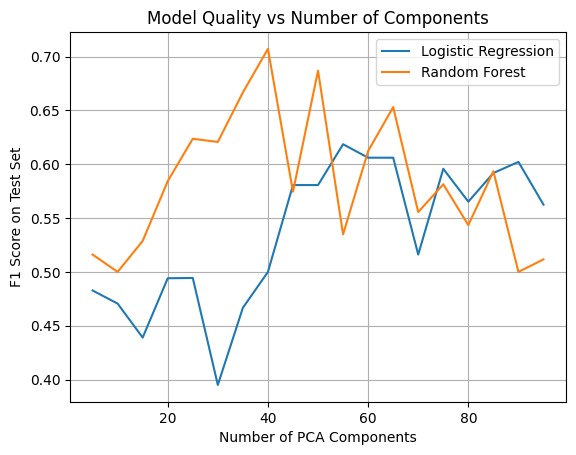

In [74]:
plt.figure()
plt.plot(components_range, logistic_scores, label='Logistic Regression')
plt.plot(components_range, forest_scores, label='Random Forest')
plt.xlabel('Number of PCA Components')
plt.ylabel('F1 Score on Test Set')
plt.title('Model Quality vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()

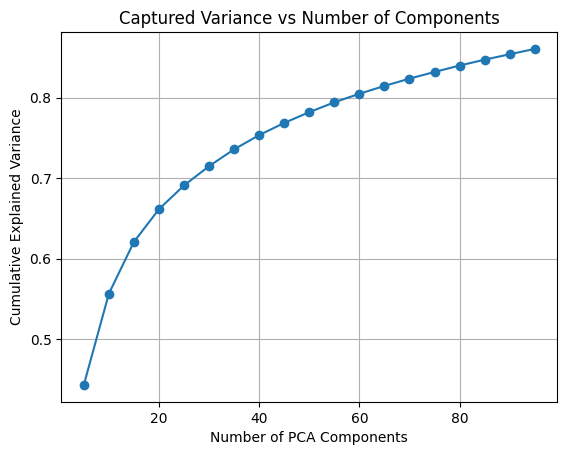

In [75]:
plt.figure()
plt.plot(components_range, explained_variance, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Captured Variance vs Number of Components')
plt.grid(True)
plt.show()

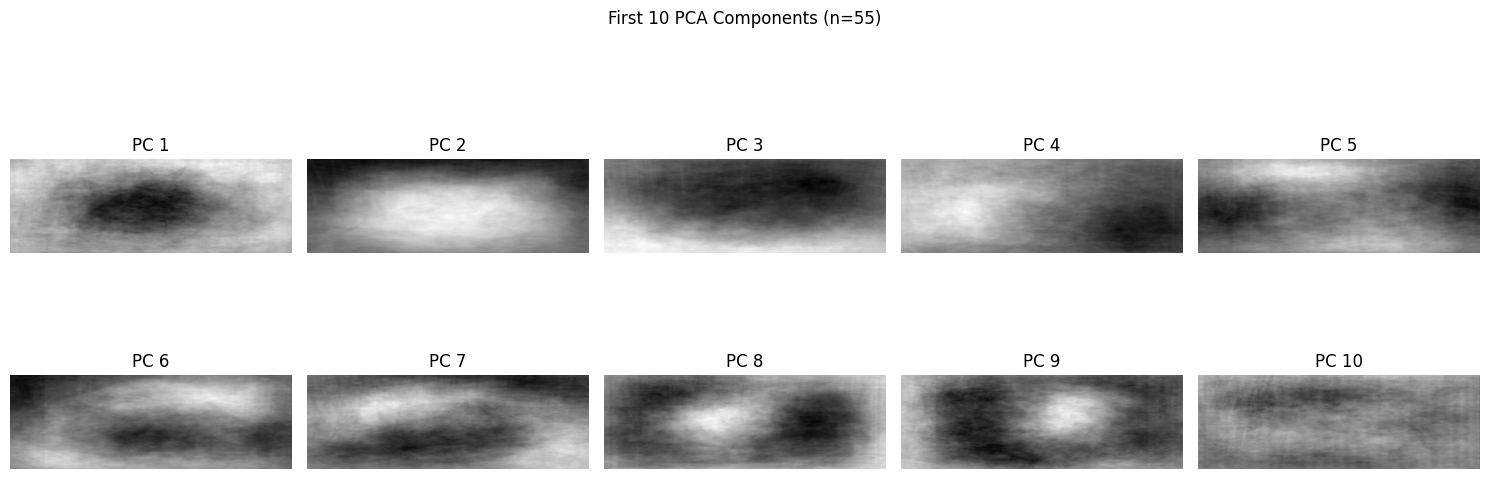

In [79]:
best_index = np.argmax(logistic_scores)
best_n_components = components_range[best_index]

pca_best = PCA(n_components=best_n_components, random_state=42)
pca_best.fit(X_train)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    component = pca_best.components_[i].reshape(256, 768)
    ax.imshow(component, cmap='gray')
    ax.set_title(f'PC {i + 1}')
    ax.axis('off')

plt.suptitle(f'First 10 PCA Components (n={best_n_components})')
plt.tight_layout()
plt.show()

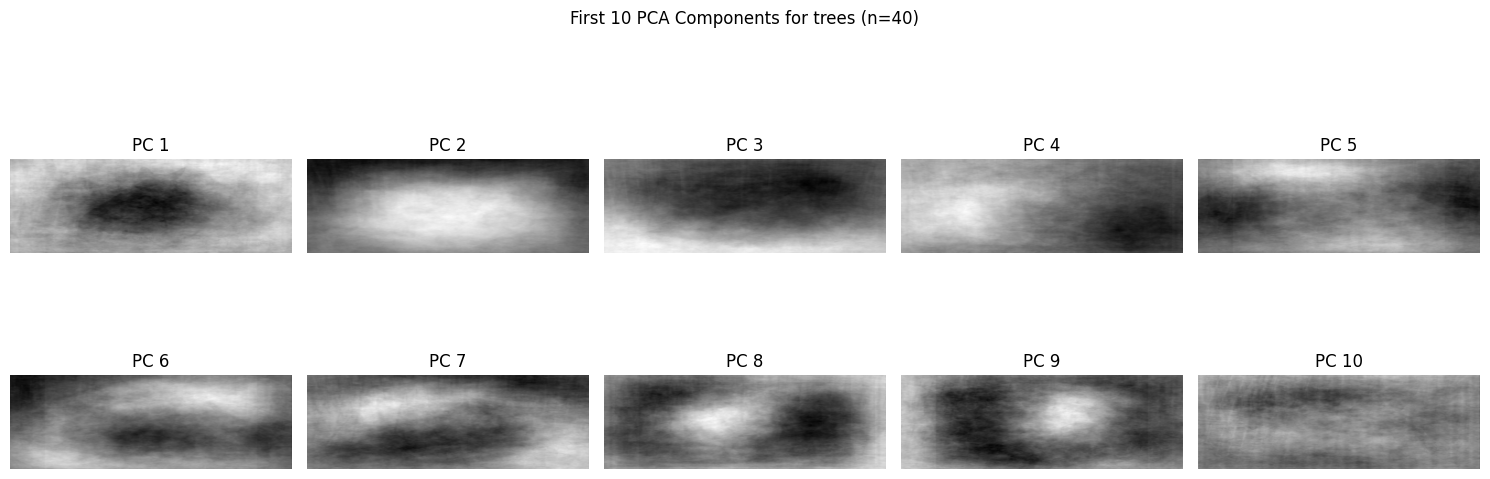

In [80]:
best_index = np.argmax(forest_scores)
best_n_components = components_range[best_index]

pca_best = PCA(n_components=best_n_components, random_state=42)
pca_best.fit(X_train)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    component = pca_best.components_[i].reshape(256, 768)
    ax.imshow(component, cmap='gray')
    ax.set_title(f'PC {i + 1}')
    ax.axis('off')

plt.suptitle(f'First 10 PCA Components for trees (n={best_n_components})')
plt.tight_layout()
plt.show()

Random Forest лучше работает при меньшем количестве компонент (до 45-50), но становится нестабильным при увеличении их числа.
Logistic Regression демонстрирует более стабильные результаты, хотя и ниже по абсолютному значению.

Если цель максимальное качество, стоит выбрать Random Forest с 45 компонентами.
Если важна стабильность модели, Logistic Regression после 50 компонент будет более надежным выбором.

При низком числе компонент логистическая регрессия не получает достаточно информации, чтобы адекватно разделить классы
-> низкие F1-значения.
Потом появляются новые полезные признаки, что улучшает предсказания.
После 60-70 компонент модель получает почти всю необходимую информацию, и выходит на плато.

То же самое для деревьев. НО
после 60-70 компонент в данных начинает накапливаться шум и дееревья переобучаются на него.